# Frequency correlation plots for simulated populations test data with nested clades from a full tree

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] < freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] < freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [6]:
min_clade_frequency = 0.1

In [7]:
precision = 4

In [8]:
data_root = "../results/builds/simulated/simulated_sample_3_test_tree"

In [9]:
data_root_full_tree = "../results/builds/simulated/simulated_sample_3_full_test_tree"

In [12]:
first_validation_timepoint = "2040-10-01"

In [13]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [14]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [15]:
#tips = np.round(tips, precision)

In [16]:
np.round(tips.head(1), precision)

,strain,timepoint,frequency
0,sample_8036_14,2040-10-01,0.0


In [17]:
(tips["frequency"] > 0).sum()

12800

In [18]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root_full_tree, sep="\t",
                             usecols=["tip", "clade_membership", "depth"])

In [19]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [22]:
tips_to_clades.head(5)

,strain,clade_membership,depth
0,sample_8156_2,a85947e,0
1,sample_8156_2,335d822,2
2,sample_8156_2,777355b,3
3,sample_8156_2,0b64e3c,4
4,sample_8176_60,a85947e,0


In [23]:
tips_to_clades.shape

(209134, 3)

In [24]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [25]:
#forecasts = np.round(forecasts, precision)

In [26]:
np.round(forecasts.head(1), 4)

,timepoint,strain,frequency,projected_frequency
0,2040-10-01,sample_8036_14,0.0,0.0


In [27]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [28]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [29]:
#full_forecasts = np.round(full_forecasts, precision)

In [30]:
full_forecasts.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
0,2040-10-01,sample_8036_14,0.000013,10.738839,13.259955,-4.634076,8.509694e-11,10.307239,2041-10-01
1,2040-10-01,sample_8036_15,0.000013,9.728878,12.905838,-30.210138,6.643109e-22,9.450799,2041-10-01
2,2040-10-01,sample_8036_16,0.000013,8.311211,11.235081,1.699620,4.792952e-08,7.564183,2041-10-01
3,2040-10-01,sample_8036_17,0.000013,7.782713,11.075434,5.112829,1.455262e-06,7.332108,2041-10-01
4,2040-10-01,sample_8036_19,0.000013,8.298003,11.485298,9.881229,1.713290e-04,8.264282,2041-10-01


## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [31]:
tips.head()

,strain,timepoint,frequency
0,sample_8036_14,2040-10-01,0.000013
1,sample_8036_15,2040-10-01,0.000013
2,sample_8036_16,2040-10-01,0.000013
3,sample_8036_17,2040-10-01,0.000013
4,sample_8036_19,2040-10-01,0.000013


In [32]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["strain"]
)

In [33]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency
0,sample_8156_2,a85947e,0,2041-04-01,0.000083
1,sample_8156_2,335d822,2,2041-04-01,0.000083
2,sample_8156_2,777355b,3,2041-04-01,0.000083
3,sample_8156_2,0b64e3c,4,2041-04-01,0.000083
4,sample_8176_60,a85947e,0,2041-04-01,0.000378


In [34]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [35]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
0,sample_8156_2,a85947e,0,2041-04-01,0.000083,2042-04-01
1,sample_8156_2,335d822,2,2041-04-01,0.000083,2042-04-01
2,sample_8156_2,777355b,3,2041-04-01,0.000083,2042-04-01
3,sample_8156_2,0b64e3c,4,2041-04-01,0.000083,2042-04-01
4,sample_8176_60,a85947e,0,2041-04-01,0.000378,2042-04-01


In [36]:
clade_tip_initial_frequencies.shape

(257175, 6)

In [37]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

In [38]:
initial_clade_frequencies.head()

,timepoint,future_timepoint,clade_membership,frequency
0,2041-04-01,2042-04-01,03c4b4f,0.002675
1,2041-04-01,2042-04-01,045f4e4,0.001685
2,2041-04-01,2042-04-01,059b765,0.008191
3,2041-04-01,2042-04-01,06e9890,0.008429
4,2041-04-01,2042-04-01,0990519,0.004366


Merge clade frequencies between adjacent years.

In [40]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [41]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final
0,2041-04-01,059b765,0.008191,0.000822
1,2041-04-01,0b64e3c,0.997913,0.999960
2,2041-04-01,0ccfdb1,0.051630,0.009739
3,2041-04-01,0d1b0d8,0.017592,0.488349
4,2041-04-01,0ddea10,0.058551,0.012744


Select clades with an initial frequency >10%.

In [43]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > %s" % min_clade_frequency).copy()

In [44]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final
1,2041-04-01,0b64e3c,0.997913,0.999960
9,2041-04-01,1e30edd,0.192975,0.249873
12,2041-04-01,348a0f0,0.360403,0.678101
13,2041-04-01,371a2df,0.167805,0.674806
17,2041-04-01,4fcd35f,0.100829,0.000596


In [45]:
large_clades.tail()

,timepoint,clade_membership,frequency,frequency_final
875,2049-10-01,eff8ef5,0.999953,0.999966
879,2049-10-01,f6b6b0b,0.239777,0.143392
883,2049-10-01,fa40799,0.999953,0.999966
886,2049-10-01,fcad47c,0.999953,0.999966
887,2049-10-01,fe7bc88,0.999953,0.999966


In [46]:
large_clades.shape

(475, 4)

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [47]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["strain"]
)

In [48]:
clade_tip_estimated_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,projected_frequency
0,sample_8156_2,a85947e,0,2041-04-01,0.000083,0.000063
1,sample_8156_2,335d822,2,2041-04-01,0.000083,0.000063
2,sample_8156_2,777355b,3,2041-04-01,0.000083,0.000063
3,sample_8156_2,0b64e3c,4,2041-04-01,0.000083,0.000063
4,sample_8176_60,a85947e,0,2041-04-01,0.000378,0.000127


In [49]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [50]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency
0,2041-04-01,03c4b4f,5.318276e-05
1,2041-04-01,045f4e4,1.906462e-04
2,2041-04-01,059b765,5.520847e-03
3,2041-04-01,06e9890,9.441379e-07
4,2041-04-01,0990519,1.933706e-04


In [51]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [52]:
complete_clade_frequencies = np.round(complete_clade_frequencies, 2)

In [53]:
complete_clade_frequencies = complete_clade_frequencies.query("frequency != frequency_final").copy()

In [54]:
complete_clade_frequencies.shape

(240, 5)

In [55]:
complete_clade_frequencies["observed_growth_rate"] = (
    complete_clade_frequencies["frequency_final"] / complete_clade_frequencies["frequency"]
)

In [56]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

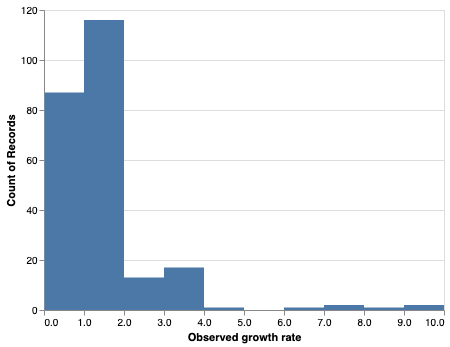

In [57]:
alt.Chart(complete_clade_frequencies).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

In [58]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [59]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year
1,2041-04-01,1e30edd,0.19,0.25,0.16,1.315789,0.842105,2041
2,2041-04-01,348a0f0,0.36,0.68,0.57,1.888889,1.583333,2041
3,2041-04-01,371a2df,0.17,0.67,0.48,3.941176,2.823529,2041
4,2041-04-01,4fcd35f,0.10,0.00,0.06,0.000000,0.600000,2041
5,2041-04-01,5198bfc,0.66,0.73,0.78,1.106061,1.181818,2041


In [60]:
complete_clade_frequencies.shape

(240, 8)

In [61]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [62]:
r

0.21924349703093013

In [63]:
p

0.0006251008071786787

In [64]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [65]:
mcc

0.425357109592482

In [66]:
confusion_matrix

{'tp': 105, 'tn': 63, 'fp': 22, 'fn': 45}

In [67]:
sum(confusion_matrix.values())

235

In [68]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.8267716535433071

In [69]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.5833333333333334

In [70]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [71]:
pseudofrequency = 0.001

In [72]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

In [73]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

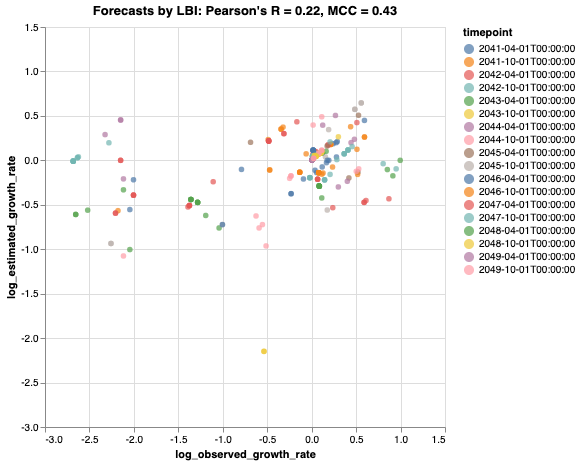

In [74]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("log_observed_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Y("log_estimated_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Color("timepoint:N"),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
).interactive()

#chart.save("forecast_log_growth_correlation_natural_lbi.svg")
chart

In [75]:
log_lower_limit

-2.782145076373832

In [76]:
complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min()

-2.682145076373832

In [77]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

In [78]:
r

0.35390524356261954

In [79]:
p

1.724753298010875e-08

In [80]:
pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

(0.21924349703093013, 0.0006251008071786787)

In [81]:
complete_clade_frequencies["observed_growth"] = (complete_clade_frequencies["observed_growth_rate"] > 1)

In [82]:
complete_clade_frequencies["estimated_growth"] = (complete_clade_frequencies["estimated_growth_rate"] > 1)

In [83]:
complete_clade_frequencies.aggregate({"observed_growth": "sum", "estimated_growth": "sum"})

observed_growth     153
estimated_growth    127
dtype: int64

In [84]:
complete_clade_frequencies["accurate_growth"] = (
    (complete_clade_frequencies["observed_growth"]) == (complete_clade_frequencies["estimated_growth"])
)

In [85]:
confusion_matrix

{'tp': 105, 'tn': 63, 'fp': 22, 'fn': 45}

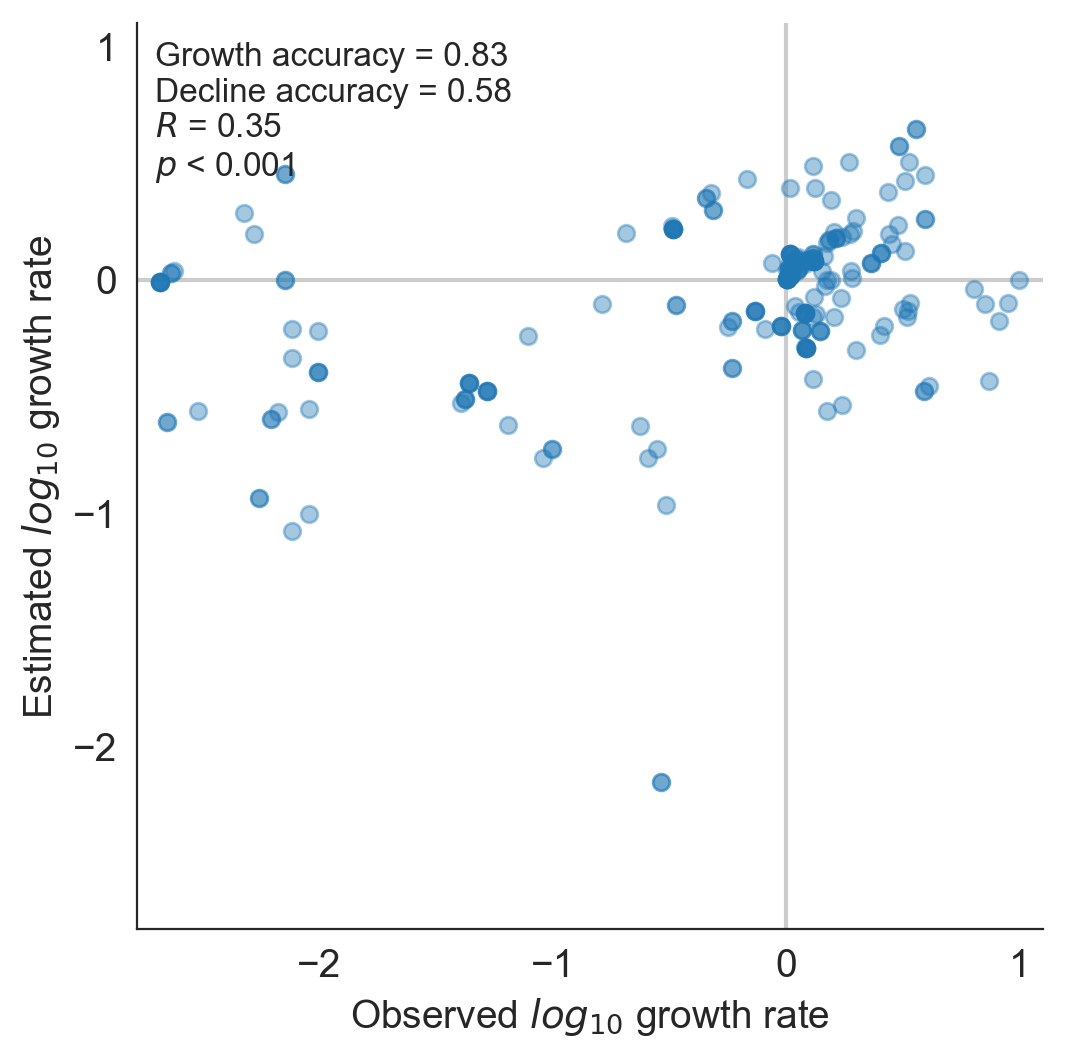

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

#plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.pdf")

In [87]:
false_positives = (complete_clade_frequencies["log_observed_growth_rate"] < 0) & (complete_clade_frequencies["log_estimated_growth_rate"] > 0)

In [88]:
confusion_matrix

{'tp': 105, 'tn': 63, 'fp': 22, 'fn': 45}

In [89]:
complete_clade_frequencies[false_positives].sort_values("frequency")

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
110,2044-04-01,6f1913b,0.14,0.00,0.40,0.000000,2.857143,2044,-2.149219,0.453925,False,True,False
114,2044-04-01,819369a,0.14,0.00,0.40,0.000000,2.857143,2044,-2.149219,0.453925,False,True,False
147,2045-04-01,781dea1,0.15,0.03,0.24,0.200000,1.600000,2045,-0.687615,0.203040,False,True,False
231,2046-10-01,6c9b489,0.19,0.09,0.45,0.473684,2.368421,2046,-0.321992,0.373143,False,True,False
322,2047-10-01,f01e466,0.19,0.00,0.30,0.000000,1.578947,2047,-2.281033,0.197533,False,True,False
245,2046-10-01,ef4e13c,0.20,0.09,0.45,0.450000,2.250000,2046,-0.344155,0.350980,False,True,False
246,2046-10-01,f1a9cc3,0.20,0.09,0.45,0.450000,2.250000,2046,-0.344155,0.350980,False,True,False
103,2044-04-01,227dcf9,0.21,0.00,0.41,0.000000,1.952381,2044,-2.324282,0.289559,False,True,False
289,2047-04-01,ff00056,0.25,0.17,0.68,0.680000,2.720000,2047,-0.166678,0.433473,False,True,False
216,2046-10-01,089dcd8,0.28,0.09,0.48,0.321429,1.714286,2046,-0.489665,0.233439,False,True,False


## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [90]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [91]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [92]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "fitness"],
    ascending=False
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [93]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2040-10-01,0.228571
1,2041-04-01,0.007143
2,2041-10-01,0.025397
3,2042-04-01,0.011905
4,2042-10-01,0.008730


Text(0,0.5,'Number of timepoints')

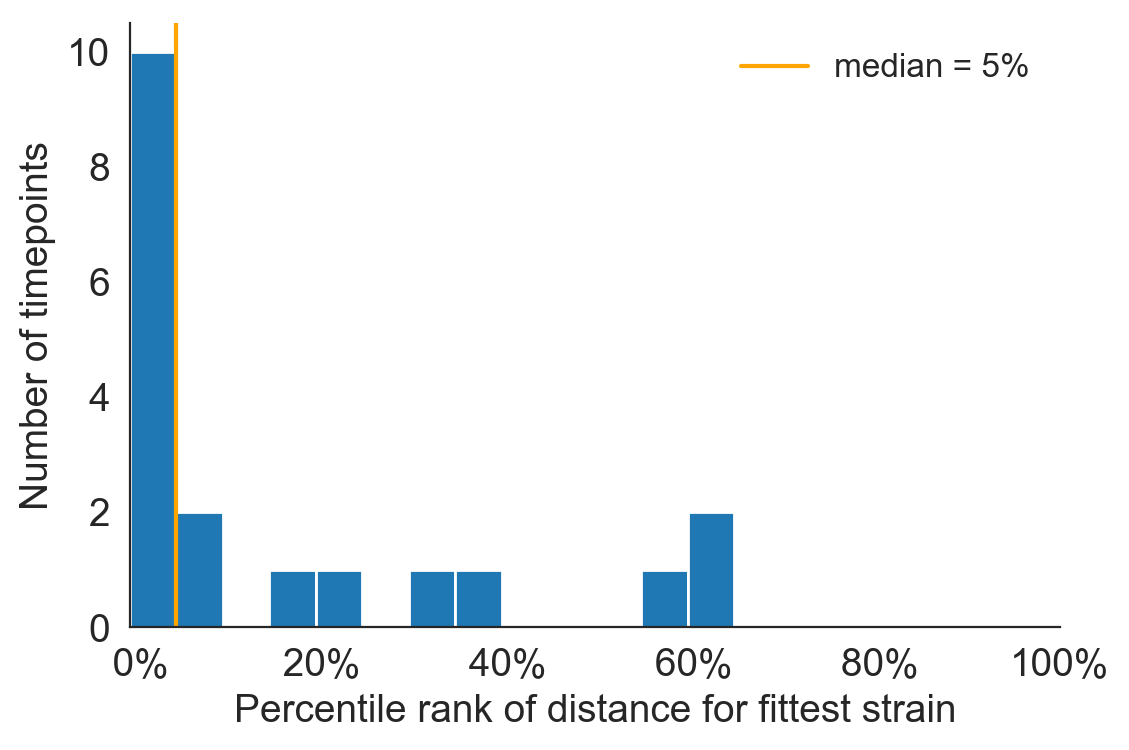

In [94]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank of distance for fittest strain")
ax.set_ylabel("Number of timepoints")

## Merge validation figures into subpanels of one figure

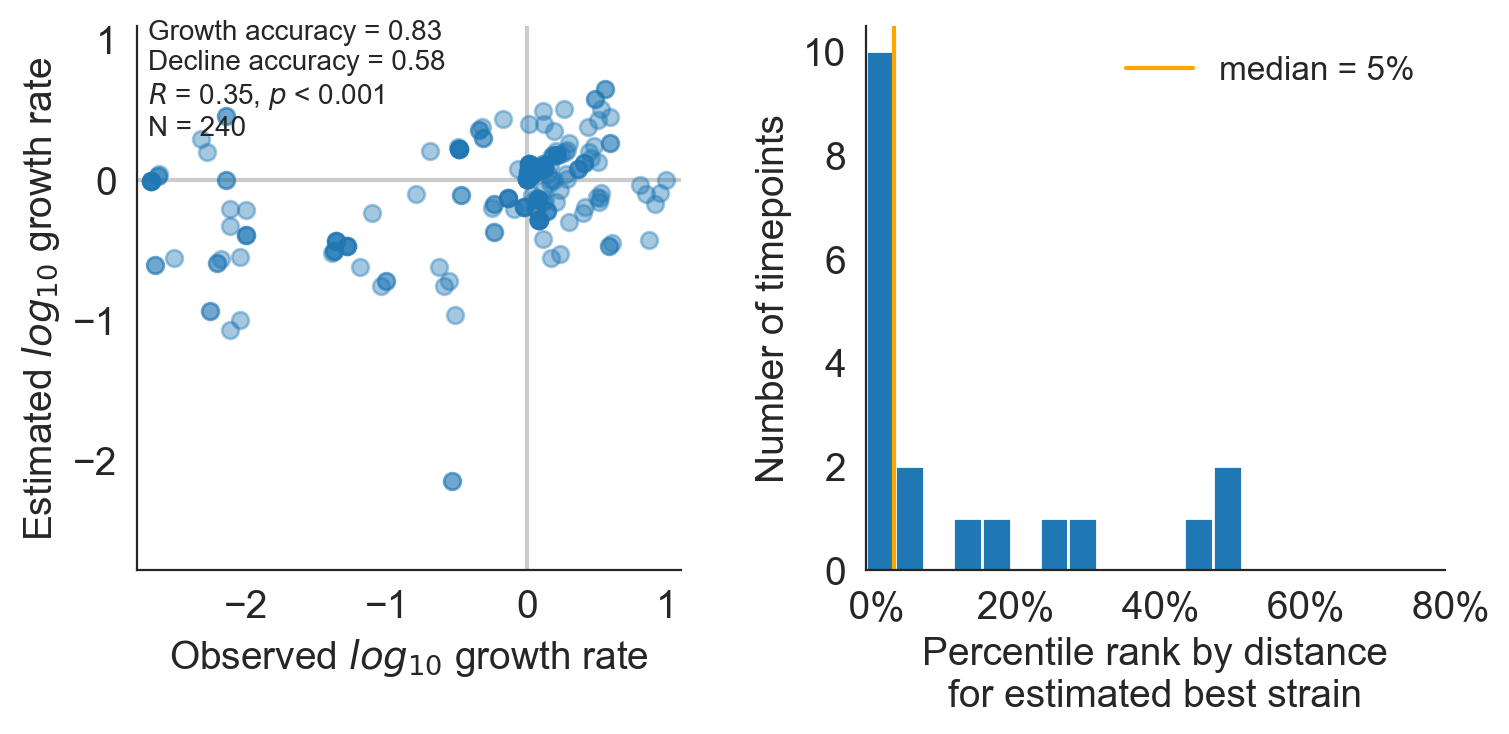

In [95]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f, %s\nN = %s" % (growth_accuracy, decline_accuracy, r, p_value, complete_clade_frequencies.shape[0]),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/test-of-best-model-for-simulated-populations.png")

In [96]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum()

13

In [97]:
best_fitness_rank_by_timepoint_df.shape

(19, 2)

In [98]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum() / float(best_fitness_rank_by_timepoint_df.shape[0])

0.6842105263157895